In [1]:
# citations:
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
# https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv


In [2]:
# John Strenio
# CS 510 DL + CV
# Professor Rhodes
# Assignment 5 Exercise 2: GANs

import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras 
from keras import layers, models
from keras.models import Model
import matplotlib.pyplot as plt

# easy access for parameter adjustments
# these are not independent
b = 32 # smaller seems better
lr = 0.0007 # bach size dependent
noise = True # not always helpful
drop = 0.3 # dis only, better, not on sigmoid
soft = 0.05 # needs to be small
beta = 0.2 # very touchy and helpful
epochs = 100
a = 0.2 # not sure tried a few


In [3]:
def noise(image):
    row,col= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noise = image + gauss
    return noise

In [4]:
# LOAD AND PREP DATA
# load fashion dset
(imgs_train, labels_train), (imgs_test, labels_test) = tf.keras.datasets.fashion_mnist.load_data()

# normalize then center imgs
imgs_train = (imgs_train / 255) 
imgs_train -= imgs_train.mean()

   

In [5]:
# BUILD GAN
# build generator
# 3-4 Dense layers: act: leaky relu, batch norm layers between
# input 100 -> output 784 to 28 x 28
# opt adam bin cross ent
gen_model = models.Sequential([
    layers.Dense(128, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=a), 
    
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=a),
    
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=a),
    
    layers.Dense(784),
    layers.LeakyReLU(alpha=a),
    layers.Reshape((28, 28), input_shape=(784,))
])
print("GENERATOR MODEL SUMMARY:")
gen_model.summary()

# build descriminator
# input 28 x 28 -> flatten -> output 1 (sigmoid bin class)
dis_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=a),
    layers.Dropout(drop),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=a),
    layers.Dropout(drop),
    
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=a),
    
    layers.Dense(1, activation='sigmoid')
])
print("DISCRIMINATOR MODEL SUMMARY:")
dis_model.summary()

opt = keras.optimizers.Adam(learning_rate=lr, beta_1=beta)
dis_model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')

# concatenate models
# freeze descriminator weights COMPILE DIS FIRST
dis_model.trainable=False

gan_model = models.Sequential()
gan_model.add(gen_model)
gan_model.add(dis_model)

print("GAN MODEL SUMMARY:")
gan_model.summary()

opt2 = keras.optimizers.Adam(learning_rate=lr, beta_1=beta)
gan_model.compile(optimizer=opt2, loss='binary_crossentropy', metrics='accuracy')




GENERATOR MODEL SUMMARY:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (N

In [6]:
def save_plot(epoch):
    fig, axs = plt.subplots(2, 2)
    cnt = 0
    for i in range(2):
        for j in range(2):
            axs[i,j].imshow(gen_model(np.random.normal(0, 1, (1,100)))[0])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("imgs/gan%d.png" % epoch)

training step 0 GLoss: 0.83 Acc: 0.0 DLoss: 0.95 Acc: 0.0
training step 1 GLoss: 0.7 Acc: 0.0 DLoss: 0.42 Acc: 0.0
training step 2 GLoss: 0.48 Acc: 0.0 DLoss: 0.3 Acc: 0.0
training step 3 GLoss: 0.36 Acc: 0.0 DLoss: 0.28 Acc: 0.0
training step 4 GLoss: 0.28 Acc: 0.0 DLoss: 0.25 Acc: 0.0
training step 5 GLoss: 0.27 Acc: 0.0 DLoss: 0.31 Acc: 0.0
training step 6 GLoss: 0.25 Acc: 0.0 DLoss: 0.23 Acc: 0.0
training step 7 GLoss: 0.23 Acc: 0.0 DLoss: 0.22 Acc: 0.0
training step 8 GLoss: 0.23 Acc: 0.0 DLoss: 0.24 Acc: 0.0
training step 9 GLoss: 0.21 Acc: 0.0 DLoss: 0.23 Acc: 0.0
training step 10 GLoss: 0.22 Acc: 0.0 DLoss: 0.23 Acc: 0.0
training step 11 GLoss: 0.23 Acc: 0.0 DLoss: 0.22 Acc: 0.0
training step 12 GLoss: 0.21 Acc: 0.0 DLoss: 0.22 Acc: 0.0
training step 13 GLoss: 0.21 Acc: 0.0 DLoss: 0.24 Acc: 0.0
training step 14 GLoss: 0.21 Acc: 0.0 DLoss: 0.22 Acc: 0.0
training step 15 GLoss: 0.22 Acc: 0.0 DLoss: 0.22 Acc: 0.0
training step 16 GLoss: 0.21 Acc: 0.0 DLoss: 0.22 Acc: 0.0
training 

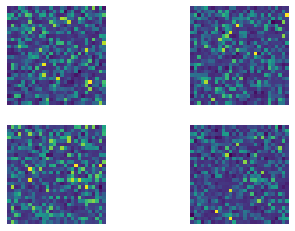

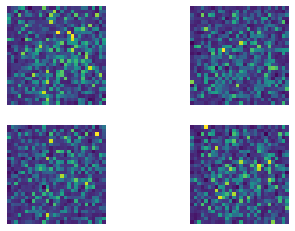

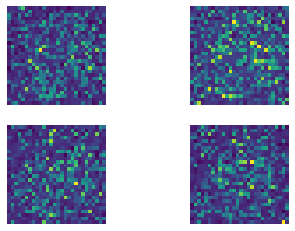

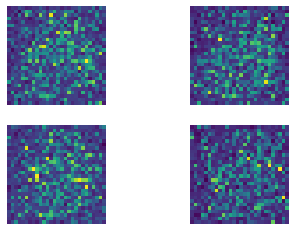

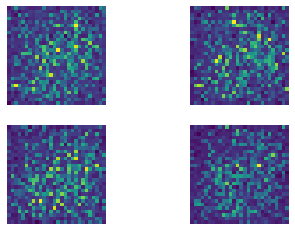

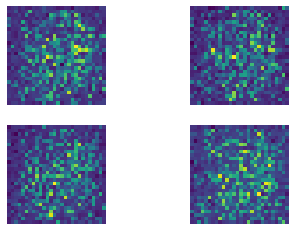

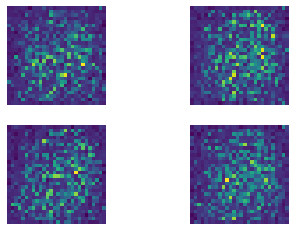

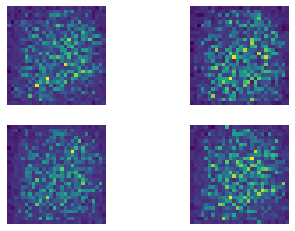

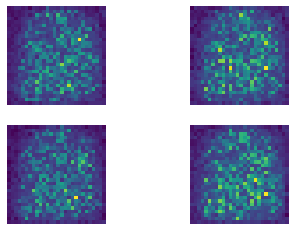

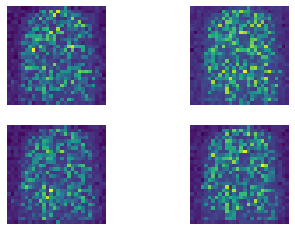

In [7]:
# TRAIN GAN

# train gan and descriminator for 100 epochs using custom training loop
dis_loss = []
gen_loss = []
for epoch in range(epochs):
    # generate B random vectors 
    gen_vecs = np.random.normal(0, 1, (b, 100)) 

    # pass vectors through generator to create "images"
    gen_imgs = np.array(gen_model.predict(gen_vecs))

    # concatenate fake and real imgs and add noise
    all_imgs = np.concatenate([gen_imgs, imgs_train[(epoch*b):((epoch+1)*b)]])

    if noise:
        for img in all_imgs:
            img = noise(img)

    # soft 0 labels (fake)
    zero_labels = np.zeros(b) + soft

    #soft 1 labels (real)
    one_labels = np.ones(b) - soft

    labels = np.concatenate([zero_labels, one_labels])
    img_label_tuples = [(all_imgs[i], labels[i]) for i in range(2*b)]

    # shuffle imgs
    np.random.shuffle(img_label_tuples)
    all_imgs = np.array([tupl[0] for tupl in img_label_tuples])
    labels = np.array([tupl[1] for tupl in img_label_tuples])

    # unfreeze discriminator weights
    dis_model.trainable=True

    # train discriminator on all images
    dis_out = dis_model.train_on_batch(all_imgs, labels)
    dis_loss.append(dis_out[0])

    # train gen
    # freeze discriminator weights
    dis_model.trainable=False

    # generate B noise samples
    gen_vecs = np.random.normal(0, 1, (b, 100))

    # create soft labels all with 1 (claiming the imgs are real)
    gen_labels = np.ones(b) - soft

    # pass noise samples through full gan
    gan_out = gan_model.train_on_batch(gen_vecs, gen_labels)
    gen_loss.append(gan_out[0])

    print('training step ' + str(epoch) + ' GLoss: ' + str(round(gan_out[0],2)) + ' Acc: ' 
        + str(round(gan_out[1],2)) + ' DLoss: ' + str(round(dis_out[0],2)) + ' Acc: ' + str(round(dis_out[1],2)))
    if epoch % 10 == 0:
        save_plot(epoch) 
        


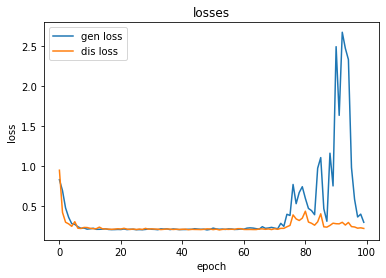

In [8]:
plt.plot(range(epochs), gen_loss, label = "gen loss")
plt.plot(range(epochs), dis_loss, label = "dis loss")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('losses')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


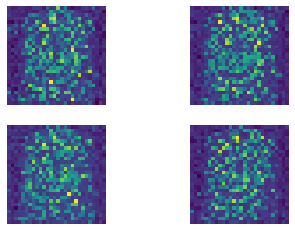

In [9]:
save_plot(99)